# Regularized Gaussian priors for recovering linear PDEs

**Notice**
- You need FEniCS and CUQIpy to run this notebook.
- I'll work on a FEniCS-free version in the future to minimize dependency.

## Introduction
A common interest with PDEs is to recover the right hand side, boundary value and initial value of a PDE, based on scattered measurement of the forward solution. In this notebook, we explore the potential use of regularized Gaussian priors in inferring Dirichlet boundary values of the Poisson equation.
\begin{aligned}
-\nabla(k\nabla u) &= f   \quad \text{in} \quad \Omega\\
                 u &= u_b \quad \text{on} \quad \partial\Omega
\end{aligned}
where $\Omega$ is a unit square domain and $\partial\Omega$ is its boundary. The mapping from $u_b$ to $u$ is linear and we can easily derive the associated Jacobian matrix. The inverse problem here is to recover $u_b$ based on some noisy meansuremnt of $u$. A natural constraint we'd like to enforce is nonnegativity ($u_b>0$).

This inverse problem also has its physical meanings. For example, in a room equipped with heaters, based on temperature measured at a few locations in the room, we'd like to estimate the capacities and layout of the heaters. (Here we assume heaters are Dirichlet boundary values)

In [1]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from utils import Poisson2D
import cuqi
import dolfin as df
# %% cuqi set up
from cuqi.distribution import Gaussian, Gamma, JointDistribution
from cuqi.implicitprior import RegularizedGaussian, RegularizedGMRF
from cuqi.problem import BayesianProblem
from cuqi.sampler import RegularizedLinearRTO, Gibbs, Conjugate, LinearRTO

## Preparation of the forward model and synthetic data

The forward problem is implemented in the accompanying `utils.py`. Given a $u_b$, the `Poisson2D.solve` will return the PDE solution based on a finite element discretization. For simplicity, we'll only infer the Dirichlet boundary values along the left edge of the square domain, and values along the rest of the boundary are assumed known.

Here we corrupt the data with Gaussian noise with mean at zero and standard deviation `noise_scale`=0.3.

/root/miniconda/lib/python3.11/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'label'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


Text(0.5, 1.0, 'y measured')

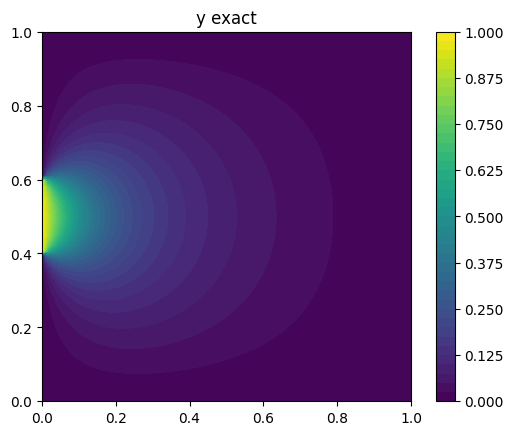

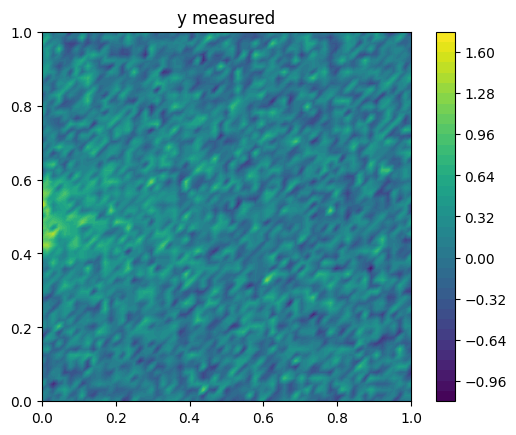

In [2]:
np.random.seed(0)
# %%
nx = 64
poisson = Poisson2D(nx, nx)
# %%
y_exact = poisson.solve_exact()
noise_scale = 0.3 #0.1 #0.05 #0.002
noise = noise_scale*np.random.randn(y_exact.size)
y_data = y_exact + noise
# %%
plt.figure()
poisson.sol.vector()[:] = y_exact
im = df.plot(poisson.sol, label='y exact')
plt.title('y exact')
plt.colorbar(im)
plt.figure()
poisson.sol.vector()[:] = y_data
im = df.plot(poisson.sol, 'o', label='y measured')
plt.colorbar(im)
plt.title('y measured')

## Solve the inverse problem in CUQIpy
We'll look at the following priors:
- Gaussian
- Regularized Gaussian with nonegativity constraint
- GMRF (precision manually set) with nonegativity constraint
- Regularized GMRF (precision manually set) with nonegativity constraint
- Regularized GMRF (precision learnt with Gibbs) with nonegativity constraint
- Regularized GMRF (precision manually set) with simplex constraint

In [3]:
# %%
model_func = cuqi.model.LinearModel(poisson.forward, adjoint=poisson.adjoint, range_geometry=poisson.V.dim(), domain_geometry=len(poisson.left_bc_dofs))

In [4]:
no_of_samples = 1000

Sample 1000 / 1000


Text(0.5, 1.0, 'Gaussian')

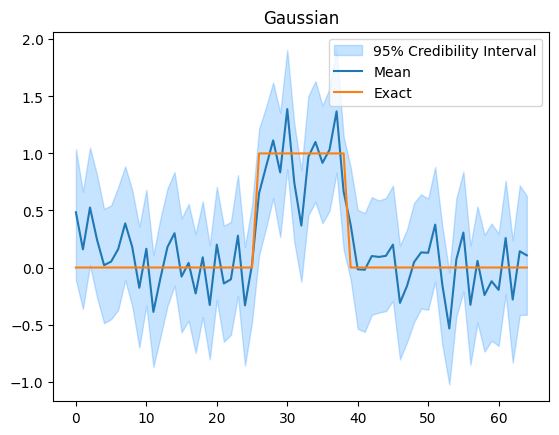

In [5]:
# %%
np.random.seed(0)
x  = Gaussian(0.0*np.ones(len(poisson.left_bc_dofs)), 1)
y  = Gaussian(model_func(x), noise_scale**2)

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_g = LinearRTO(posterior)
samples_g = sampler_g.sample(no_of_samples)

plt.figure()
samples_g.plot_ci(exact=np.array(list(poisson.bc_left.get_boundary_values().values())))
plt.title('Gaussian')

Sample 1000 / 1000


Text(0.5, 1.0, 'Regularized Gaussian')

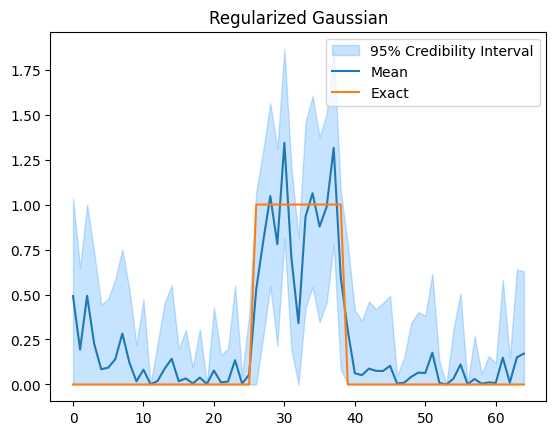

In [6]:
# %%
np.random.seed(0)
x  = RegularizedGaussian(0.0*np.ones(nx+1), 1, constraint = "nonnegativity")
y  = Gaussian(model_func(x), noise_scale**2)

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_rg = RegularizedLinearRTO(posterior)
samples_rg = sampler_rg.sample(no_of_samples)

# %%
plt.figure()
samples_rg.plot_ci(exact=np.array(list(poisson.bc_left.get_boundary_values().values())))
plt.title('Regularized Gaussian')

Sample 1000 / 1000


Text(0.5, 1.0, 'GMRF')

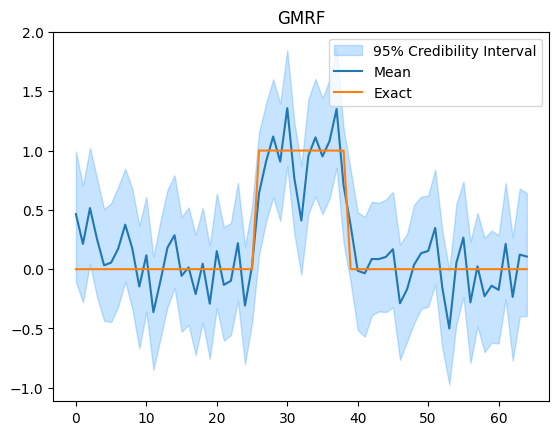

In [7]:
# GMRF
np.random.seed(0)
x = cuqi.distribution.GMRF(np.zeros(nx+1), 1)
y = Gaussian(model_func(x), noise_scale**2)

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_gmrf = cuqi.sampler.LinearRTO(posterior)
samples_gmrf = sampler_gmrf.sample(no_of_samples)
# %%
plt.figure()
samples_gmrf.plot_ci(exact=np.array(list(poisson.bc_left.get_boundary_values().values())))
plt.title('GMRF')

Sample 1000 / 1000


Text(0.5, 1.0, 'Regularized GMRF')

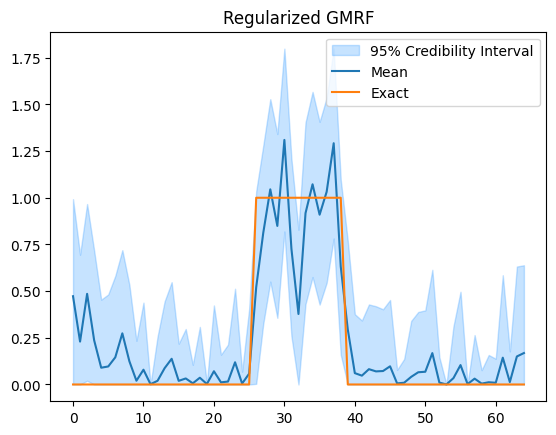

In [8]:
# regularized GMRF
np.random.seed(0)
x = RegularizedGMRF(np.zeros(nx+1), 1, constraint = "nonnegativity")
y = Gaussian(model_func(x), noise_scale**2)

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_rgmrf = RegularizedLinearRTO(posterior)
samples_rgmrf = sampler_rgmrf.sample(no_of_samples)
# %%
plt.figure()
samples_rgmrf.plot_ci(exact=np.array(list(poisson.bc_left.get_boundary_values().values())))
plt.title('Regularized GMRF')

Warmup 200 / 200
Sample 1000 / 1000


Text(0.5, 1.0, 'Regularized GMRF with Gibbs')

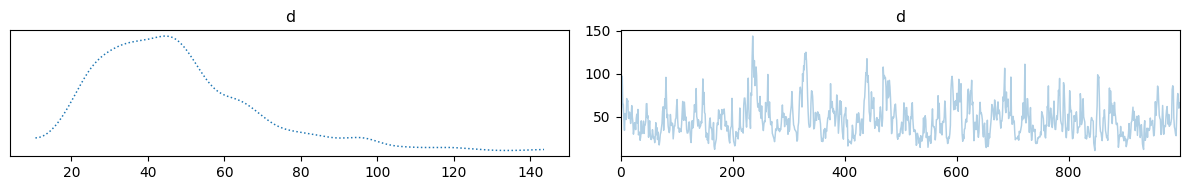

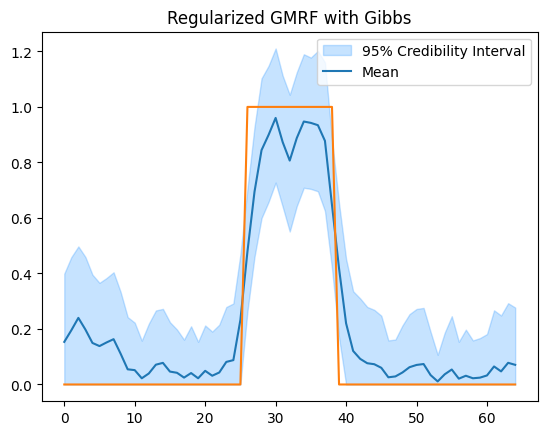

In [5]:
# Regularized GMRF with Gibbs (to learn precision as well)
np.random.seed(0)
d = Gamma(1, 1e-4)
x = RegularizedGMRF(np.zeros(nx+1), prec = lambda d:d, constraint = "nonnegativity")
y = Gaussian(model_func(x), noise_scale**2)

# Combine into a joint distribution
joint = JointDistribution(d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(np.array(list(poisson.bc_left.get_boundary_values().values())), label='x exact')
plt.title("Regularized GMRF with Gibbs")

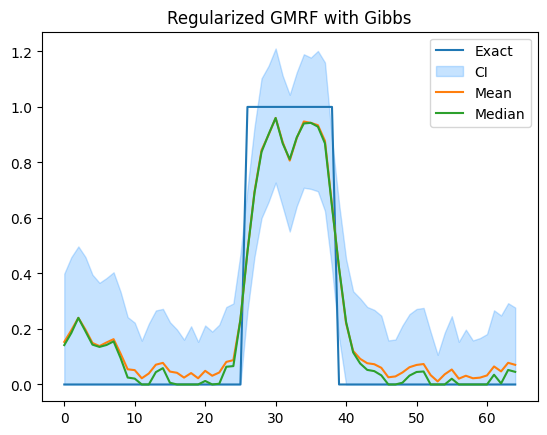

In [10]:
plt.figure()
plt.plot(np.array(list(poisson.bc_left.get_boundary_values().values())))

samples['x'].plot_ci()
samples['x'].plot_median()

plt.title("Regularized GMRF with Gibbs")
plt.legend(['Exact', 'CI', 'Mean', 'Median'])

In [19]:
def _projectSimplex(x, radius = 1):
    ''' Condat, Laurent. "Fast projection onto the simplex and the l 1 ball." Mathematical Programming 158.1-2 (2016): 575-585.
        worst case O(n^2), average case O(nlogn)
        Technically not the faster algorithm, but the simplest
    '''
    u = np.flip(np.sort(x)) # worst case: O(n^2), average case: O(nlogn)
    K = len(x)-1
    accum = np.sum(u)
    while (accum - radius)/(K+1) >= u[K] and K > 0:
        accum -= u[K]
        K -= 1
    tau = (accum - radius)/(K+1)
    return np.maximum(x-tau, 0)

project_simplex = lambda x : _projectSimplex(x, radius = np.sum(np.array(list(poisson.bc_left.get_boundary_values().values()))))

In [ ]:
# regularized GMRF
np.random.seed(0)
x = RegularizedGMRF(np.zeros(nx+1), 40, projector = project_simplex)
y = Gaussian(model_func(x), noise_scale**2)

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_rgmrf = RegularizedLinearRTO(posterior)
samples_rgmrf = sampler_rgmrf.sample(no_of_samples)

Text(0.5, 1.0, 'Regularized GMRF with simplex projection')

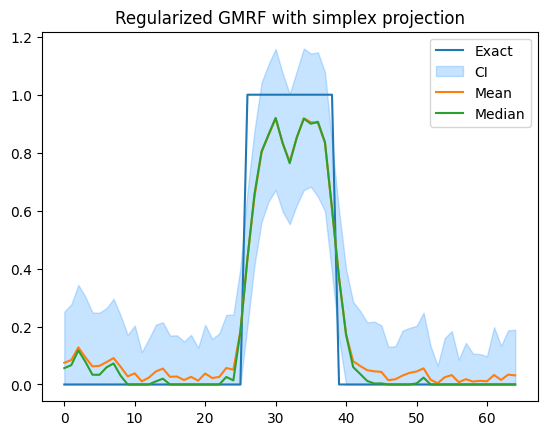

In [27]:
# %%
plt.figure()
plt.plot(np.array(list(poisson.bc_left.get_boundary_values().values())))
samples_rgmrf.plot_ci()
samples_rgmrf.plot_median()
plt.legend(['Exact', 'CI', 'Mean', 'Median'])
plt.title('Regularized GMRF with simplex projection')

## More on constraints
Constraints that are good (I should say perfect) to have:
1. nonnegativity, i.e., x >= 0
2. simplex, i.e., sum(x) = 1 and x >= 0
3. box, i.e., x_min <= x <= x_max
4. linear, i.e., Ax = b
5. mass conservation, i.e., sum(x) = C (I assume this actually a speical case of 4)